---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import plotly.express as px
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

np.random.seed(42)


Specify input and output directories and color palette

In [2]:
version = 'v3.3'

inputs = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m/v3/'
outputs = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m/v3/'

alignment = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/LandCoverChange/data/outputs/cropped/crop5c_30m/population.tif'

titles = [
    'OtherProbability',
    'BII'
]

Load Datasets

In [3]:
# Load the CSV file into a DataFrame
csv_file_path = inputs + 'cluster_3_data.csv'
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m/v3/cluster_3_data.csv'

Standardize the data columns for clustering

In [ ]:
# Standardization
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(df[titles])

Perform K-means clustering

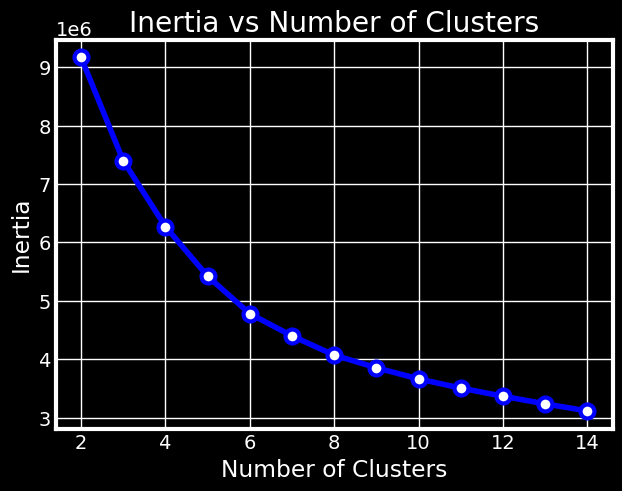

In [ ]:
from sklearn.cluster import KMeans

# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=600)
    kmeans.fit(X)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
# Set a dark background style for the plot
plt.style.use('dark_background')

# Plotting the data
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3, color='blue')

# Setting labels and title with light color for visibility
plt.title('Inertia vs Number of Clusters', color='white')
plt.xlabel('Number of Clusters', color='white')
plt.ylabel('Inertia', color='white')

# Display the plot
plt.show()


Determine the appropriate number of clusters using KneeLocator

In [ ]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

6


Fit the appropriate number of clusters to the data

In [ ]:
# Initialize the Kmeans object
# Using the identified knee
kmeans = KMeans(n_clusters=(kn.knee), random_state=42, n_init=10)

# Using a manually-assigned knee (optional)
# kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Run the fit! This adds the ".labels_" attribute
kmeans.fit(X);

# Save the cluster labels
df["cluster"] = kmeans.labels_

df.head()

,x,y,OtherProbability,UrbanProbability,population,Flood_Hazards,Heat_Hazards,BII,cluster
0,-84.474630,10.158081,0.719398,2.827213e-15,0.000000,0.013273,0.418647,0.898350,1
1,-84.474353,10.158081,0.812856,2.715926e-15,0.000000,0.011635,0.423732,0.896329,1
2,-84.474075,10.158081,0.778973,2.819386e-15,0.000000,0.094986,0.428817,0.897263,0
3,-84.472964,10.158081,0.861869,5.000000e-04,0.000000,0.015130,0.429978,0.898086,1
4,-84.472686,10.158081,0.862931,5.000000e-04,0.074747,0.015326,0.429080,0.897583,3


In [ ]:
# Count the number of rows for each cluster and sort them to see which clusters have the greatest number of rows
cluster_counts = df['cluster'].value_counts().sort_values(ascending=False)

# Display the counts
print('Number of Pixels per Cluster')
print(cluster_counts)
# print(df.dtypes)

Number of Pixels per Cluster
cluster
4    642081
1    525679
2    451162
0    204231
3     54526
5     20889
Name: count, dtype: int64


In [ ]:
# Convert index and values to lists for plotting
clusters = cluster_counts.index.tolist()
counts = cluster_counts.values.tolist()

# Define minimum and maximum marker sizes
min_size = 10  # Minimum marker size in pixels
max_size = 150  # Maximum marker size in pixels

# Normalize the counts to scale between min_size and max_size
max_count = max(counts)
normalized_sizes = [(count / max_count) * (max_size - min_size) + min_size for count in counts]

# Mapping cluster IDs to specific colors for discrete legend entries
color_map = {cluster: color for cluster, color in zip(clusters, px.colors.qualitative.Plotly)}

# Initialize the figure
fig = go.Figure()

# Add scatter trace for each cluster
for cluster, size, count in zip(clusters, normalized_sizes, counts):
    fig.add_trace(go.Scatter(
        x=[cluster],
        y=[1],  # Y-values are constant; they only serve to display the relative sizes
        mode='markers',
        marker=dict(
            size=[size],
            color=[color_map[cluster]],  # Use specific color for each cluster
            opacity=0.5
        ),
        name=f'Cluster {cluster}: {count}',  # Name each trace to appear in the legend
    ))

# Update the layout for dark mode and adjust axis lines
fig.update_layout(
    title='Number of Pixels per Cluster',
    title_font_color='white',
    paper_bgcolor='#303030',
    plot_bgcolor='#303030',
    xaxis=dict(
        title='Cluster',
        title_font_color='white',
        tickfont_color='white',
        gridcolor='#505050',
        showline=True,
        linewidth=2,
        linecolor='white',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='#505050',  # Adjust 0 axis line to match the grid
    ),
    yaxis=dict(
        showticklabels=False,
        gridcolor='#505050',
        showline=True,
        linewidth=2,
        linecolor='white',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='#505050',  # Adjust 0 axis line to match the grid
    ),
    legend=dict(
        font_color='white',
        bgcolor='#404040',
        title_font_color='white'
    )
)

# Show the interactive plot
fig.show()


Make a multi-bar chart for each cluster

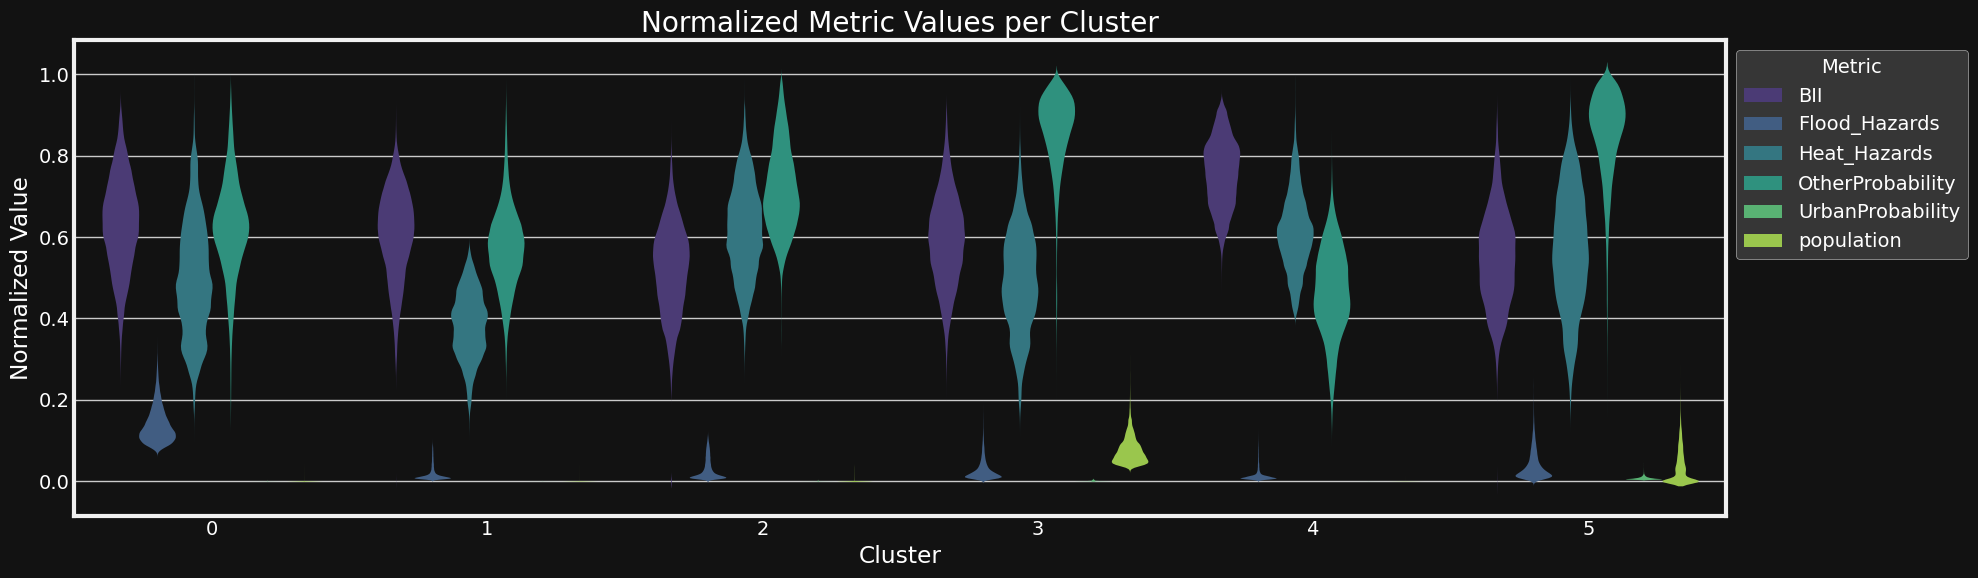

In [ ]:
# Convert df to long format
# Select columns to include in the melt operation, excluding 'x' and 'y'
columns_to_melt = df.columns.difference(['x', 'y', 'cluster'])

# Perform the melt operation with the selected columns
long_df = pd.melt(df, id_vars=['cluster'], value_vars=columns_to_melt, var_name='Metric', value_name='Normalized Value')

# Example to add space between clusters (e.g., 0, 1, 2) becomes (0, 2, 4) to add space
cluster_ids = sorted(long_df['cluster'].unique())
spacing_factor = 2  # Adjust the spacing factor as needed
cluster_mapping = {old_id: i * spacing_factor for i, old_id in enumerate(cluster_ids)}

# Apply the mapping to create spaced cluster IDs
long_df['spaced_cluster'] = long_df['cluster'].map(cluster_mapping)

# Now, plot with the updated 'spaced_cluster' instead of 'cluster'
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 6))
fig.patch.set_facecolor('#121212')
ax.set_facecolor('#121212')

# Adjusted violin plot to use 'spaced_cluster'
palette = sns.color_palette("muted", n_colors=len(long_df['Metric'].unique()))
violin_parts = sns.violinplot(x='spaced_cluster', y='Normalized Value', hue='Metric', data=long_df,
                              palette='viridis', split=False, linewidth=0, scale='count')

# Compute median values considering the new spaced clusters
medians = long_df.groupby(['spaced_cluster', 'Metric'])['Normalized Value'].median().reset_index()

# Update plotting of medians and other elements as needed
# Similar to previous steps, just ensure to use 'spaced_cluster'

# Customizations for text color, etc.
ax.set_title('Normalized Metric Values per Cluster', color='white')
ax.set_xlabel('Cluster', color='white')
ax.set_ylabel('Normalized Value', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Correct the x-axis labels to reflect original cluster IDs, not spaced IDs
ax.set_xticklabels(cluster_ids)

# Adjust legend and other customizations as before
legend = ax.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
plt.setp(legend.get_texts(), color='white')
plt.setp(legend.get_title(), color='white')
legend.get_frame().set_facecolor('#404040')

plt.tight_layout()
plt.show()


Here we see how each one of the clusters is composed of a different combination of values of each index we're clustering on.<br>
Let's put together some high-level takeaways about the implications of each of these.<br>
* Land in Clusters 0 and 3 are most of the human settlements. 0 is more biodiverse and 

 settlements should be considered for **asdf**, as this means they have a high combination of land cover change probability and biodiversity. The primary difference between these two clusters is that cluster 2 has high flood hazard probability whereas cluster 4 does not.
    * *summary here*

Plot the clusters across space

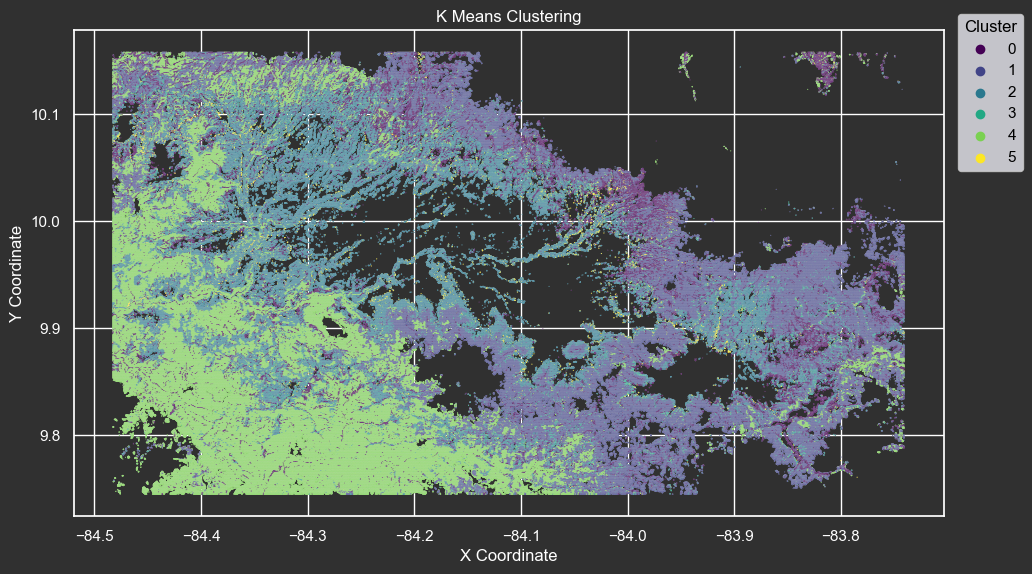

In [ ]:
# Manually specified colors for each category
colors = ['red', 'darkgreen', 'tan', 'grey', 'green']

# Set the style of the visualization with a dark background
sns.set(style="darkgrid")

# Create a scatter plot with the custom palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='x', 
    y='y', 
    hue='cluster', 
    palette='viridis', 
    data=df, 
    s=0.5  # Point size
)

# Adding title and labels with a light color for visibility against the dark background
plt.title('K Means Clustering', color='white')
plt.xlabel('X Coordinate', color='white')
plt.ylabel('Y Coordinate', color='white')

# Change the color of ticks and labels for visibility
plt.xticks(color='white')
plt.yticks(color='white')

# Modify legend for better visibility on dark background
legend = plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1.05), frameon=True)
plt.setp(legend.get_texts(), color='black')  # Set the legend text color
plt.setp(legend.get_title(), color='black')  # Set the legend title color

# Set the face and edge color of the figure to match the dark theme
plt.gcf().set_facecolor('#303030')
plt.gca().set_facecolor('#303030')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom']. set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

# Display the plot
plt.show()

Cluster 0, shown in RED is the zone at highest risk of biodiversity loss.
Prioritization: Conservation

Cluster 1, shown in GREEN is the zone where development risk is low and the suitability of urban development is high. 

Cluster 2

Cluster 3...


In [ ]:
# Open the raster dataset and read its bounds and resolution
with rasterio.open(alignment) as dataset:
    bounds = dataset.bounds
    resolution_x, resolution_y = dataset.res  # Resolution in units of the dataset's CRS
    crs = dataset.crs  # Coordinate Reference System of the original raster

transform = dataset.transform

# Use the bounds from the original raster for setting up your analysis
x_min, x_max = bounds.left, bounds.right
y_min, y_max = bounds.bottom, bounds.top

# Assuming that the resolution is uniform in both directions, or choosing one as standard
resolution = resolution_x  # or resolution_y, if different and more appropriate


# Calculate grid dimensions correctly, adding 1 to ensure coverage
width = int(np.ceil((x_max - x_min) / resolution))
height = int(np.ceil((y_max - y_min) / resolution))

# Initialize grid with a nodata value
grid = np.full((height, width), -9999)  # Nodata value

# Assign cluster values to the grid
for _, row in df.iterrows():
    x_idx = int((row['x'] - x_min) / resolution)
    y_idx = int((row['y'] - y_min) / resolution)
    # Ensure indices are within bounds
    if 0 <= x_idx < width and 0 <= y_idx < height:
        grid[height - 1 - y_idx, x_idx] = row['cluster']  # Flip y-axis to match image coordinates

# Correct the CRS specification using a valid EPSG code
crs = "EPSG:4326"  # WGS84 Latitude/Longitude system

# Define geospatial metadata including the corrected CRS
meta = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': -9999,
    'width': width,
    'height': height,
    'count': 1,
    'crs': crs,  # Corrected CRS specification
    'transform': transform
}

# Specify the filename
filename = f'{version}_subclusters.tif'

# Concatenate the directory and filename to get the full output path
output_path = outputs + filename

# Save to GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(grid.astype(np.float32), 1)


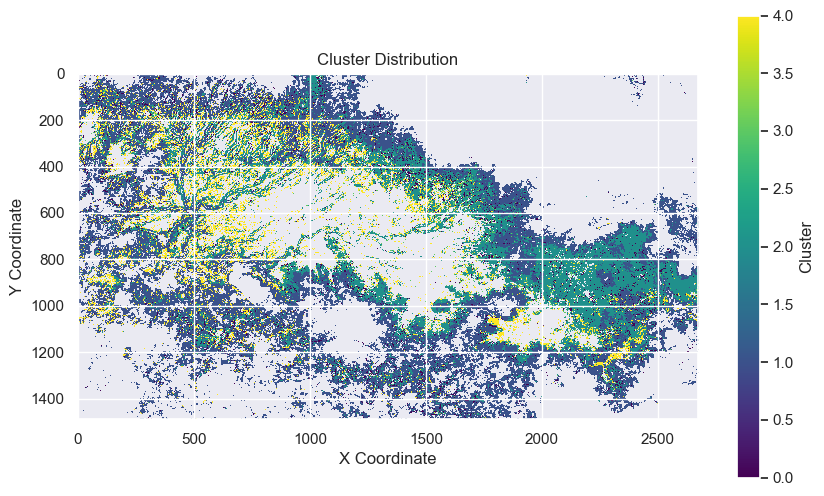

In [ ]:
# Plot the Exported Raster
# Note: We're using a masked array to handle the nodata values correctly in the plot
masked_grid = np.ma.masked_where(grid == -9999, grid)

plt.figure(figsize=(10, 6))
plt.imshow(masked_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title('Cluster Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()